In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from google.colab import drive
from tqdm import tqdm
import glob
import keras
from keras.models import *
from keras.layers import *
from keras import layers
import tensorflow as tf
import os

%matplotlib inline

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
print(tf.__version__)

2.12.0


In [4]:
drive.mount("/content/drive/")
%cd drive/MyDrive/EchoNet-LVH1

Mounted at /content/drive/
/content/drive/.shortcut-targets-by-id/1r0GllLLSpP3LnKwarePEwf0HFuWN50JV/EchoNet-LVH1


In [5]:
data = pd.read_csv("MeasurementsList.csv")
data.drop(columns=["Unnamed: 0"], inplace=True)
mask = (data["Calc"] == "LVPWd") | (data["Calc"] == "LVIDd") | (data["Calc"] == "IVSd")
data = data[mask]
data

,HashedFileName,Calc,CalcValue,Frame,X1,X2,Y1,Y2,Frames,FPS,Width,Height,split
0,0X66EFA90ADBC0BA4F,IVSd,0.838136,94,634,659,314,286,198,19.970,1024.0,768,train
1,0X66EFA90ADBC0BA4F,LVPWd,0.828865,94,512,529,571,538,198,19.970,1024.0,768,train
2,0X66EFA90ADBC0BA4F,LVIDd,5.453681,94,530,634,535,314,198,19.970,1024.0,768,train
3,0XAD41A03F4A5B9ABC,LVPWd,0.761081,101,465,491,524,498,202,19.965,1024.0,768,train
5,0XAD41A03F4A5B9ABC,LVIDd,3.997847,101,491,632,498,366,202,19.965,1024.0,768,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46693,0X1ED05E23735FBF84,LVIDd,5.196031,190,391,473,322,484,191,10.716,800.0,600,train
46694,0X1ED05E23735FBF84,LVPWd,0.603678,190,468,479,489,507,191,10.716,800.0,600,train
46695,0XB522F9C3DCF9FB3F,LVIDd,3.908540,34,411,502,485,302,63,19.968,1024.0,768,train
46696,0XB522F9C3DCF9FB3F,LVPWd,0.889633,34,391,411,527,485,63,19.968,1024.0,768,train


In [6]:
MAX_SEQ_LENGTH = 32
IMAGE_DIMS = (224, 224)
BATCH_SIZE = 16
IMAGE_CHANNELS = 3
IMAGE_OUT_DIMS = 4
learning_rate = 1e-3

In [7]:
def load_avi(path, target_frame=0, target_res=IMAGE_DIMS):
  for batch in ["Batch1/", "Batch2/", "Batch3/", "Batch4/"]:
    capture = cv2.VideoCapture(batch + path)
    capture.set(cv2.CAP_PROP_POS_FRAMES, target_frame-1)
    frame = None
    try:
      res, frame = capture.read()
      frame = frame[:,:,[2,1,0]]
      frame = cv2.resize(frame, target_res, interpolation=cv2.INTER_CUBIC)
    except Exception as e:
      continue
    break
  capture.release()
  return np.array(frame)/255.

In [8]:
data["HashedFileName"].value_counts()
sub_mask = data["HashedFileName"].value_counts() >= 3
mask = data["HashedFileName"].isin(data["HashedFileName"].value_counts()[sub_mask].index)
clean_data = data[mask]

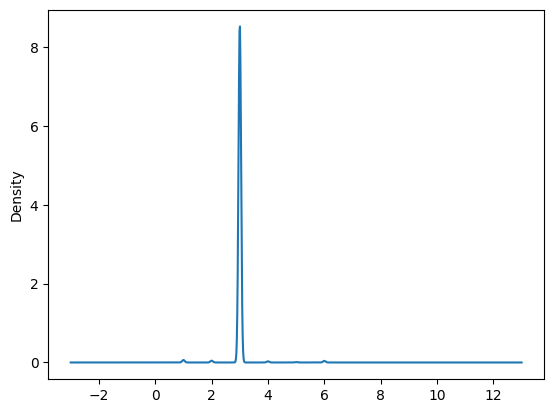

In [9]:
data["HashedFileName"].value_counts().plot.kde();

In [10]:
IVSd  = "IVSd"
LVIDd = "LVIDd"
LVPWd = "LVPWd"

calc_data  = clean_data.groupby(by="HashedFileName")[["Calc"]].value_counts().to_frame().query("Calc == @IVSd or Calc == @LVIDd or Calc == @LVPWd")
calc_mask  = calc_data.groupby(level=[0]).size() == 3
calc_mask  = calc_mask[calc_mask == True]
clean_data = clean_data[clean_data["HashedFileName"].isin(calc_mask.index)]
# data_mask = (clean_data["Calc"] == IVSd) | (clean_data["Calc"] == LVIDd) | (clean_data["Calc"] == LVPWd)
# clean_data = clean_data[data_mask]
clean_data = clean_data[~clean_data.duplicated(["HashedFileName", "Calc"])]
clean_data.reset_index(inplace=True, drop=True)
clean_data

,HashedFileName,Calc,CalcValue,Frame,X1,X2,Y1,Y2,Frames,FPS,Width,Height,split
0,0X66EFA90ADBC0BA4F,IVSd,0.838136,94,634,659,314,286,198,19.970,1024.0,768,train
1,0X66EFA90ADBC0BA4F,LVPWd,0.828865,94,512,529,571,538,198,19.970,1024.0,768,train
2,0X66EFA90ADBC0BA4F,LVIDd,5.453681,94,530,634,535,314,198,19.970,1024.0,768,train
3,0XAD41A03F4A5B9ABC,LVPWd,0.761081,101,465,491,524,498,202,19.965,1024.0,768,train
4,0XAD41A03F4A5B9ABC,LVIDd,3.997847,101,491,632,498,366,202,19.965,1024.0,768,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34852,0X1ED05E23735FBF84,LVIDd,5.196031,190,391,473,322,484,191,10.716,800.0,600,train
34853,0X1ED05E23735FBF84,LVPWd,0.603678,190,468,479,489,507,191,10.716,800.0,600,train
34854,0XB522F9C3DCF9FB3F,LVIDd,3.908540,34,411,502,485,302,63,19.968,1024.0,768,train
34855,0XB522F9C3DCF9FB3F,LVPWd,0.889633,34,391,411,527,485,63,19.968,1024.0,768,train


<Axes: ylabel='Density'>

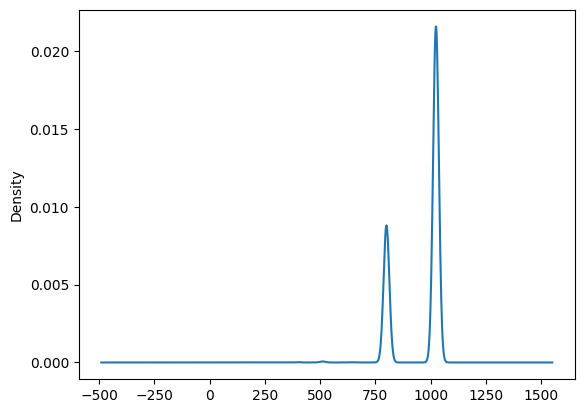

In [11]:
clean_data["Width"].plot.kde()

In [12]:
def run_inference(paths):
  batch = np.zeros((BATCH_SIZE, IMAGE_DIMS[1], IMAGE_DIMS[0], IMAGE_CHANNELS))
  y = np.zeros((BATCH_SIZE, 8))
  for batch_id, path in enumerate(paths):
    target_frame = clean_data.loc[clean_data["HashedFileName"] == path[:-4], "Frame"].iloc[0]
    temp = np.zeros((8))
    for idx, measurement in enumerate([IVSd, LVPWd]):
      temp[idx*4:(idx+1)*4] = clean_data.loc[(clean_data["HashedFileName"] == path[:-4]) & (clean_data["Calc"] == measurement), :][["X1", "Y1", "X2", "Y2"]].values.flatten()
    y[batch_id, :]  = temp.copy()
    batch[batch_id] = load_avi(path, target_frame)
  return batch, y

In [13]:
class PrepareImagesGen(tf.keras.utils.Sequence):
    def __init__(self, df):
        self.df = df.copy()
        self.batch_size = BATCH_SIZE
        self.input_size = IMAGE_DIMS
        self.n = len(self.df)
        
    def on_epoch_end(self):
        pass
    
    def __getitem__(self,index):
        paths = self.df["HashedFileName"].unique()[index*16:((index+1)*16)]
        paths = [path + ".avi" for path in paths]
        X,y = run_inference(paths)
        return X,y
    
    def __len__(self):
        return self.n//self.batch_size

train_gen = PrepareImagesGen(clean_data)

In [14]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)
    
    out_1  = convolution_block(dspp_input, kernel_size=1, dilation_rate=1, padding="same")
    out_6  = convolution_block(dspp_input, kernel_size=3, dilation_rate=3, padding="same")
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6, padding="same")
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=9, padding="same")

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [15]:
# https://github.com/KostasStefanidis/Semantic-Segmentation/blob/2d97dec22f47155ea5b84bc49e42dbeb207d0070/utils/models/SegmentationModels.py#L348

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    backbone = tf.keras.applications.EfficientNetV2S(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    #for layer in resnet50.layers:
        #layer.trainable = True
    x = backbone.get_layer("top_activation").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        8,
        interpolation="bilinear",
    )(x)
    input_b = backbone.get_layer("block2d_add").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1, use_bias=False)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)

    return keras.Model(inputs=model_input, outputs=model_output)

In [16]:
def get_points_np(preds, threshold=0.3):
    """Gets the centroid of heatmaps.
    Args:
        preds (np.ndarray): Input heatmaps. shape=(n, h, w, c)
        threshold (float, optional): Value below which input pixels are ignored. Defaults to 0.3.
    Returns:
        np.ndarray: Centroid locations. shape=(n, c, 2)
    """
    #preds[preds < threshold] = 0 NEEDS TO BE CORRECTED OR WILL CAUSE PROBLEMS
    Y, X = np.mgrid[:IMAGE_DIMS[0], :IMAGE_DIMS[1]]
    X, Y = tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(Y, dtype=tf.float32)
    np.seterr(divide='ignore', invalid='ignore')
    x_pts = tf.math.reduce_sum(X[None, ..., None] * preds, axis=(-3, -2)) / tf.math.reduce_sum(preds, axis=(-3, -2))
    y_pts = tf.math.reduce_sum(Y[None, ..., None] * preds, axis=(-3, -2)) / tf.math.reduce_sum(preds, axis=(-3, -2))
    return tf.transpose(tf.convert_to_tensor([x_pts, y_pts], dtype=tf.float32), perm=[1,2,0])

In [22]:
class MUC(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    preds = get_points_np(y_pred)
    return tf.linalg.normalize(tf.reduce_mean(tf.math.square(tf.keras.backend.batch_flatten(preds) - y_true), axis=-1), ord="euclidean", axis=-1) # NORMALIZE LOSS FOR CLEARER METRICS

In [23]:
model = DeeplabV3Plus(224,4)
model.compile(loss=MUC(), optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate,epsilon=1e-8))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

In [27]:
model.fit(train_gen, batch_size = BATCH_SIZE, epochs=1, shuffle=False, verbose=True)